above50sma
0% [############################# ] 100% | ETA: 00:00:00
Stat                 above50sma
-------------------  ------------
Start                2003-03-18
End                  2014-09-20
Risk-free rate       0.00%

Total Return         16.63%
Daily Sharpe         0.18
Daily Sortino        0.19
CAGR                 1.35%
Max Drawdown         -31.66%
Calmar Ratio         0.04

MTD                  1.59%
3m                   0.46%
6m                   0.90%
YTD                  -5.05%
1Y                   -0.53%
3Y (ann.)            6.79%
5Y (ann.)            0.13%
10Y (ann.)           1.53%
Since Incep. (ann.)  1.35%

Daily Sharpe         0.18
Daily Sortino        0.19
Daily Mean (ann.)    1.67%
Daily Vol (ann.)     9.54%
Daily Skew           -1.20
Daily Kurt           17.24
Best Day             3.60%
Worst Day            -7.80%

Monthly Sharpe       0.19
Monthly Sortino      0.25
Monthly Mean (ann.)  1.82%
Monthly Vol (ann.)   9.77%
Monthly Skew         -0.50
Monthly Kurt    

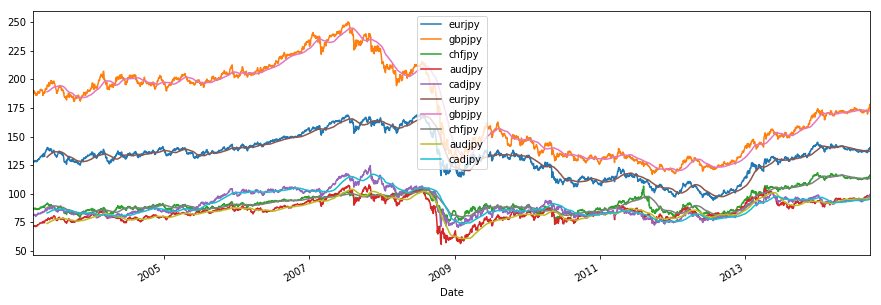

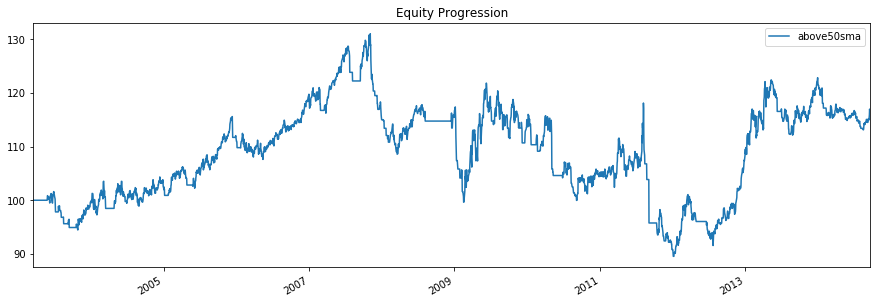

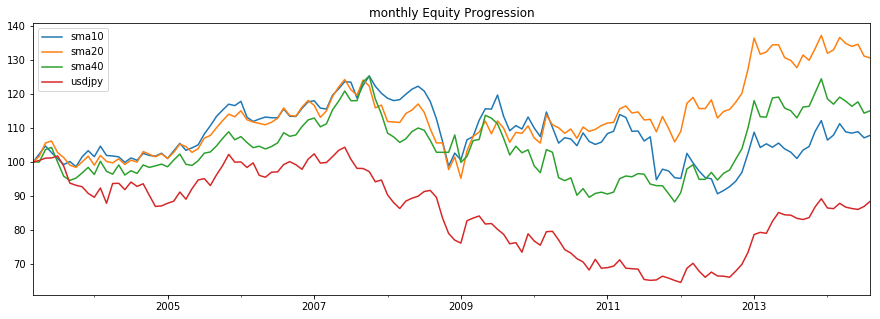

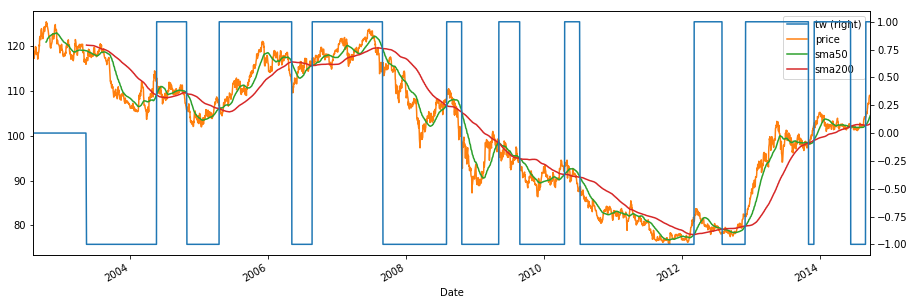

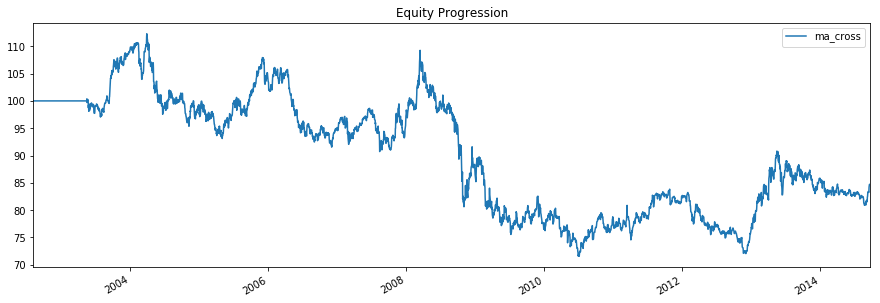

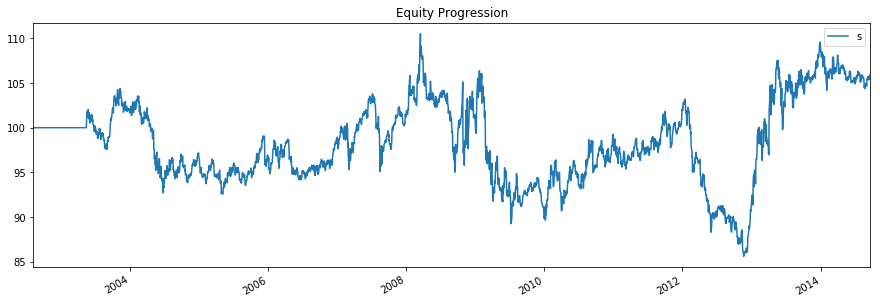

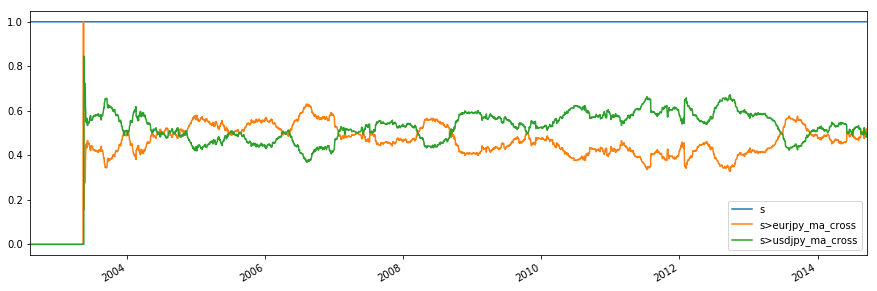

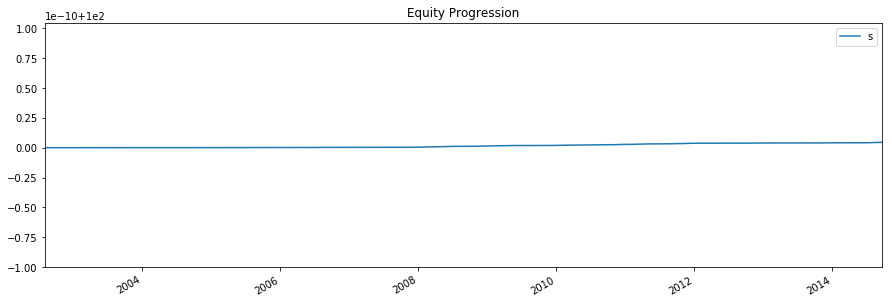

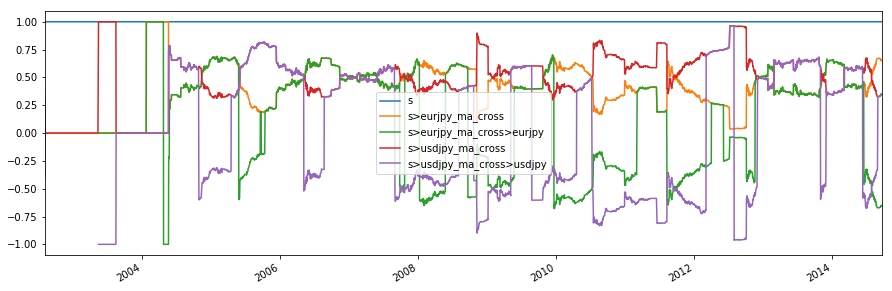

In [1]:
import bt
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

data = bt.get('eurjpy,gbpjpy,chfjpy,audjpy,cadjpy', start='1027890000', end='1317330000')

sma = data.rolling(50).mean()

#print 'First Graph'
plot = bt.merge(data, sma).plot(figsize=(15, 5))


class SelectWhere(bt.Algo):
    def __init__(self, signal):
        self.signal = signal
    def __call__(self, target):
        if target.now in self.signal.index:
            sig = self.signal.loc[target.now]
            selected = list(sig.index[sig])
            target.temp['selected'] = selected
        return True
    
signal = data > sma

s = bt.Strategy('above50sma', [SelectWhere(data > sma),bt.algos.WeighEqually(),bt.algos.Rebalance()])

t = bt.Backtest(s, data)

#print 'First Calculation'
res = bt.run(t)

#print 'Second Graph'
res.plot()

#print 'First Output Table'
print 
res.display()

def above_sma(tickers, sma_per=50, start='1027890000', end='1317330000', name='above_sma'):
    data = bt.get(tickers, start='1027890000', end='1317330000')
    sma = data.rolling(sma_per).mean()
    s = bt.Strategy(name, [SelectWhere(data > sma),bt.algos.WeighEqually(),bt.algos.Rebalance()])
    return bt.Backtest(s, data)

def long_only_ew(tickers, start='1027890000', end='1317330000', name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),bt.algos.SelectAll(),bt.algos.WeighEqually(),bt.algos.Rebalance()])
    data = bt.get(tickers, start='1027890000', end='1317330000')
    return bt.Backtest(s, data)

tickers = 'eurjpy,gbpjpy,chfjpy,audjpy,cadjpy'
sma10 = above_sma(tickers, sma_per=10, name='sma10')
sma20 = above_sma(tickers, sma_per=20, name='sma20')
sma40 = above_sma(tickers, sma_per=40, name='sma40')
benchmark = long_only_ew('usdjpy', name='usdjpy')

#print 'Second Calculation'
res2 = bt.run(sma10, sma20, sma40, benchmark)

#print 'Third Graph'
res2.plot(freq='m')

#print 'Second Output Table'
print 
res2.display()

class WeighTarget(bt.Algo):
    def __init__(self, target_weights):
        self.tw = target_weights
    def __call__(self, target):
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]
            target.temp['weights'] = w.dropna()
        return True
    
data = bt.get('usdjpy', start='1027890000', end='1317330000')
sma50 = data.rolling(50).mean()
sma200 = data.rolling(200).mean()

tw = sma200.copy()
tw[sma50 > sma200] = 1.0
tw[sma50 <= sma200] = -1.0
tw[sma200.isnull()] = 0.0

tmp = bt.merge(tw, data, sma50, sma200)
tmp.columns = ['tw', 'price', 'sma50', 'sma200']

#print 'Forth Graph'
ax = tmp.plot(figsize=(15,5), secondary_y=['tw'])

ma_cross = bt.Strategy('ma_cross', [WeighTarget(tw),bt.algos.Rebalance()])
t = bt.Backtest(ma_cross, data)

#print 'Third Calculation'
res = bt.run(t)

#print 'Fifth Graph'
res.plot()

def ma_cross(ticker, start='1027890000', end='1317330000',short_ma=50, long_ma=200, name='ma_cross'):
    data = bt.get(ticker, start=start, end=end)
    short_sma = data.rolling(short_ma).mean()
    long_sma  = data.rolling(long_ma).mean()
    
    tw = long_sma.copy()
    tw[short_sma > long_sma] = 1.0
    tw[short_sma <= long_sma] = -1.0
    tw[long_sma.isnull()] = 0.0
    
    s = bt.Strategy(name, [WeighTarget(tw), bt.algos.Rebalance()], [ticker])
    return bt.Backtest(s, data)

t1 = ma_cross('eurjpy', name='eurjpy_ma_cross')
t2 = ma_cross('usdjpy', name='usdjpy_ma_cross')

#print 'Forth Calculation'
res = bt.run(t1, t2)

data = bt.merge(res['eurjpy_ma_cross'].prices, res['usdjpy_ma_cross'].prices)

s = bt.Strategy('s', [bt.algos.SelectAll(),bt.algos.WeighInvVol(),bt.algos.Rebalance()])

t = bt.Backtest(s, data)

#print 'Fifth Calculation'
res = bt.run(t)

#print 'Sixth Graph'
res.plot()

#print 'Seventh Graph'
res.plot_weights()


t1 = ma_cross('eurjpy', name='eurjpy_ma_cross')
t2 = ma_cross('usdjpy', name='usdjpy_ma_cross')

res = bt.run(t1, t2)

data = bt.merge(res['eurjpy_ma_cross'].prices, res['usdjpy_ma_cross'].prices)

s = bt.Strategy('s', [bt.algos.SelectAll(),bt.algos.WeighInvVol(),bt.algos.Rebalance()],[t1.strategy,t2.strategy])

t = bt.Backtest(s, data)

#print 'Sixth Calculation'
res = bt.run(t)

#print 'Eighth Graph'
res.plot()

#print 'Ninth Graph'
res.plot_weights()
